In [93]:
import pandas as pd
import DataLoading
import NN_classes
import torch
import matplotlib.pyplot as plt
import numpy as np

In [33]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w_ext_o_dummy/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.4
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"LB")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

input_f_sc01_Network_Existing_Generation_Full_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
86
input_f_sc01_N

In [34]:
def calculate_lb_from_dfs_out(dfs_out,execution): 
    return (dfs_out["Network_Existing_Generation_Full"].sum(axis=1) - dfs_out[execution].sum(axis=1))

def calculate_lb_from_ts_out(ts_out,ex):
    b= "Network_Existing_Generation_Full"
    all_ts_out_ex = torch.concat((ts_out["train"][ex],ts_out["test"][ex],ts_out["val"][ex]))
    all_ts_out_benchmark = torch.concat((ts_out["train"][b],ts_out["test"][b],ts_out["val"][b]))
    return all_ts_out_benchmark-all_ts_out_ex
    

def find_xthbest_model_params_from_df(df_losses,loss_to_sort,xth_best=1):
    return df_losses.sort_values(by =loss_to_sort)[xth_best-1:xth_best]

def create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run = True):
    #First, extract params from row
    model_type = row.Model_type.item()
    model_type = tuple(map(int, model_type.replace("(","").replace(")","").split(', ')))
    dor = row.Dor.item()
    lr = row.Lr.item()
    nb_e = row.Epochs.item()

    relu_out = row.Relu_out.item()
    np =row.Np.item()
    bs = row.Batch_size.item()
    alpha = row.alpha.item()
    MAE = row.MAE.item()
    
    if str(alpha) == "0.0": 
        alpha = "0"

    if row.Min_val.item(): 
        mt = "min_val"
    else: 
        mt = "all_epochs"
    
    #Then create model of given type
    m = NN_classes.create_model(model_type,input_size, dropout_ratio= dor,relu_out =relu_out,inter=True,inter_size=inter_size)
    
    #Finally, extract model state from dict
    
    #m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
    m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}ro_{bs}bs_{alpha}ill_{MAE}MAE"

    if cluster_run:
        #m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
        path = f"ResultsClusterRuns/trained_models/{hyperloop_name}/{mt}/model_{m_name}.pth"
    else:
        path = f"trained_models/{hyperloop_name}/{mt}/model_{m_name}.pth"

    m.load_state_dict(torch.load(path))
    m.eval()
    
    return m

In [67]:
hyperloop_name = "RTS24_AC_12w_dummy_0.3_v0.4_PF_LB_0_40"
#df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
df_losses = pd.read_csv(f"ResultsClusterRuns/Loss_results_csv/{hyperloop_name}.csv",index_col=0)

[172, 258, 62, 38, 19, 9]


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


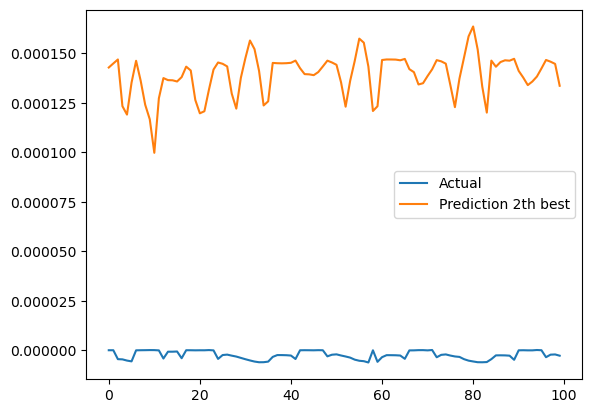

In [109]:
#Visualisation of multiple models in input order

cluster_run = True
f = df_losses.alpha ==0.0
loss_to_sort = "Te_l_t_mse"

ex = all_executions[16]

ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()

s = 100
e=s+100
plt.plot(ex_out[s:e],label = "Actual")

for xth_best in [2]: 
    row = find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=cluster_run)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

In [105]:
i=0
all_counts = pd.DataFrame()

for ex in all_executions:
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    lb_actual = dfs_out[ex].sum(axis=1).to_numpy().flatten()
    
    lb_est =  m(ex_in.float())[0].detach().numpy().flatten()
    
    both_positive_count = np.sum((lb_est > 0) & (lb_actual > 0))
    both_negative_count = np.sum((lb_est < 0) & (lb_actual < 0))
    opposite_sign_count = np.sum((lb_est * lb_actual) < 0)
    BZ = np.sum((lb_est==0) & (lb_actual == 0))
    OZ = np.sum((lb_est * lb_actual) == 0)


    row_lb = pd.DataFrame({"exec":ex,"BP":both_positive_count, "BN":both_negative_count,"OS":opposite_sign_count,"OZ":OZ,"BZ":BZ,}, index = [i])
    all_counts = pd.concat([all_counts,row_lb],axis=0)
    i+=1
    

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.recipro

In [107]:
all_counts

,exec,BP,BN,OS,OZ,BZ
0,Network_Existing_Generation_Full,0,0,0,2184,0
1,Network_Line_In_N_101_N_102_cac1,1744,0,436,4,0
2,Network_Line_In_N_101_N_103_cac1,1617,1,563,3,0
3,Network_Line_In_N_101_N_105_cac1,1898,0,284,2,0
4,Network_Line_In_N_102_N_104_cac1,1870,0,312,2,0
5,Network_Line_In_N_102_N_106_cac1,1685,0,497,2,0
6,Network_Line_In_N_103_N_109_cac1,1725,0,457,2,0
7,Network_Line_In_N_103_N_124_cac1,1785,38,355,6,0
8,Network_Line_In_N_104_N_109_cac1,2065,0,115,4,0
9,Network_Line_In_N_105_N_110_cac1,1852,0,330,2,0
